In [1]:
from astropy.io import fits
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ckdtree as kdtree 
import itertools
import matplotlib as mpl
from astroML.density_estimation import XDGMM
from astroML.plotting.tools import draw_ellipse
from extreme_deconvolution import extreme_deconvolution as ed
from matplotlib.patches import Ellipse
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)
#print mpl.rcParams.keys()
import pdb
%matplotlib inline

In [2]:
#read in TGAS data for and matched sample for magnitudes 
tgas = fits.getdata("stacked_tgas.fits", 1)
tgasRave = fits.getdata('tgas-rave.fits', 1)
tgasApass = fits.getdata('tgas-matched-apass-dr9.fits')
tgasWise = fits.getdata('tgas-matched-wise.fits')
tgas2mass = fits.getdata('tgas-matched-2mass.fits')

In [3]:
print tgas.dtype.names

('hip', 'tycho2_id', 'solution_id', 'source_id', 'random_index', 'ref_epoch', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax', 'parallax_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'ra_dec_corr', 'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr', 'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr', 'parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr', 'astrometric_n_obs_al', 'astrometric_n_obs_ac', 'astrometric_n_good_obs_al', 'astrometric_n_good_obs_ac', 'astrometric_n_bad_obs_al', 'astrometric_n_bad_obs_ac', 'astrometric_delta_q', 'astrometric_excess_noise', 'astrometric_excess_noise_sig', 'astrometric_primary_flag', 'astrometric_relegation_factor', 'astrometric_weight_al', 'astrometric_weight_ac', 'astrometric_priors_used', 'matched_observations', 'duplicated_source', 'scan_direction_strength_k1', 'scan_direction_strength_k2', 'scan_direction_strength_k3', 'scan_direction_strength_k4', 'scan_direction_mean_k1', 'scan_direction_mean_k2', 'scan_direction_mean

In [4]:
nonNans = ~np.isnan(tgasRave['TEFF']) & ~np.isnan(tgasRave['LOGG']) & ~np.isnan(tgasRave['FE_H'])
    
dwarfs = (tgasRave['LOGG'] < 5.) & (tgasRave['LOGG'] > 4.2) & (tgasRave['TEFF'] > 4500.)
#cut out low logg and temperatures outside well populated area 

tgasRave = tgasRave[nonNans & dwarfs]

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


In [5]:
#read in Adrian's distances from sampling the posterior 
ndist = 200
nfiles = 16
dist = None #np.zeros(len(tgasMatched), ndist)
for j in range(1,nfiles+1):
    with h5py.File("distance-samples-{:02d}.hdf5".format(j)) as f:
        if dist is None:
            dist = f['distance'][:,:ndist]
        else:
            dist = np.concatenate((dist, f['distance'][:,:ndist]))

#calculate the median distance from the posterior and proper error for cuts 
medianDist = np.median(dist, axis=1)
err = np.sqrt(tgas['parallax_error']**2. + 0.3**2.)


In [6]:
#various cuts to select sample 
proj = 'twins'
ndist = ndist
nNeighbors = 1024
magSN = 16.
sigMax = 1.086/magSN
maxDist = 8000. #1000. #pc
fracErrorDistance = 1.

if proj ==  'twins':
    minDist = 0.0 #pc
    parallaxSN = 16.
    galacticLatMin = 0. #degrees
    galacticLatMax = None #degrees
if proj == 'dust':
    minDist = 250. #pc
    parallaxSN = 5.
    galacticLatMin = 0.  #degrees 
    galacticLatMax = 10. #degrees
    
mags = ['bmag', 'gmag', 'vmag', 'rmag', 'imag']
errors = ['e_bmag', 'e_gmag', 'e_vmag', 'e_rmag', 'e_imag']
wavelength = [420., 475., 520., 658., 806.]

In [7]:
#current cut: no magnitudes are NaNs, 0 < errors < sigMax, 
#print np.sum(tgas['parallax']/err > parallaxSN)

noNans = ~np.isnan(tgasApass['bmag']) & ~np.isnan(tgasApass['vmag']) & \
         ~np.isnan(tgasApass['gmag']) & ~np.isnan(tgasApass['rmag']) & \
         ~np.isnan(tgasApass['imag'])

posErrors = (tgasApass['e_bmag'] > 0) & (tgasApass['e_vmag'] > 0) & \
            (tgasApass['e_gmag'] > 0) & (tgasApass['e_rmag'] > 0) & \
            (tgasApass['e_imag'] > 0)

lowPhotError = (tgasApass['e_bmag'] < sigMax) & (tgasApass['e_vmag'] < sigMax) & \
               (tgasApass['e_gmag'] < sigMax) & (tgasApass['e_rmag'] < sigMax) & \
               (tgasApass['e_imag'] < sigMax) 
        
lowPhotError_IR = (tgas2mass['j_cmsig'] < sigMax) & (tgas2mass['h_cmsig'] < sigMax) & \
                  (tgas2mass['k_cmsig'] < sigMax)  & (tgasWise['w1sigmpro'] < sigMax) & \
                  (tgasWise['w2sigmpro'] < sigMax) & (tgasWise['w3sigmpro'] < sigMax) 
            
noDust = (medianDist < maxDist) & (np.abs(tgas['b']) > galacticLatMin)

apassMatch = tgasApass['matched']

wiseMatch = tgasWise['matched']

twoMassMatch = tgas2mass['matched']

goodDistance = tgas['parallax']/err > parallaxSN

hasDust = medianDist >= minDist

raveMatch = np.in1d(tgas['source_id'], tgasRave['source_id'])

if galacticLatMax: inDisk = np.abs(tgas['b'] <= galacticLatMax)

matched = goodDistance & noNans & posErrors & lowPhotError & noDust &\
           apassMatch & raveMatch & twoMassMatch & wiseMatch & lowPhotError_IR 

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in greater
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in less
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in less


In [8]:
print np.sum(tgasWise['w4sigmpro'] < sigMax)

187352


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


In [9]:
tgasMatched = tgas[matched]
magsMatched = tgasApass[matched]
wiseMatched = tgasWise[matched]
twoMassMatched = tgas2mass[matched]
errMatched = err[matched]
raveInd = np.in1d(tgasRave['source_id'], tgasMatched['source_id'])
raveMatched = tgasRave[raveInd]

In [10]:
#raveNonNan = ~np.isnan(raveMatched['TEFF']) & ~np.isnan(raveMatched['LOGG'])
#raveMatched = raveMatched[raveNonNan]

In [11]:
print 'Number of tgas stars: ', len(tgas)
print 'Number of matched stars: ', np.sum(matched)
print 'Percent matched = ', 100 - (len(tgas) - np.sum(matched))/np.float(len(tgas))*100., '%'
#print np.min(magsMatched['gmag']), np.max(magsMatched['gmag'])

Number of tgas stars:  2057050
Number of matched stars:  904
Percent matched =  0.0439464281374 %


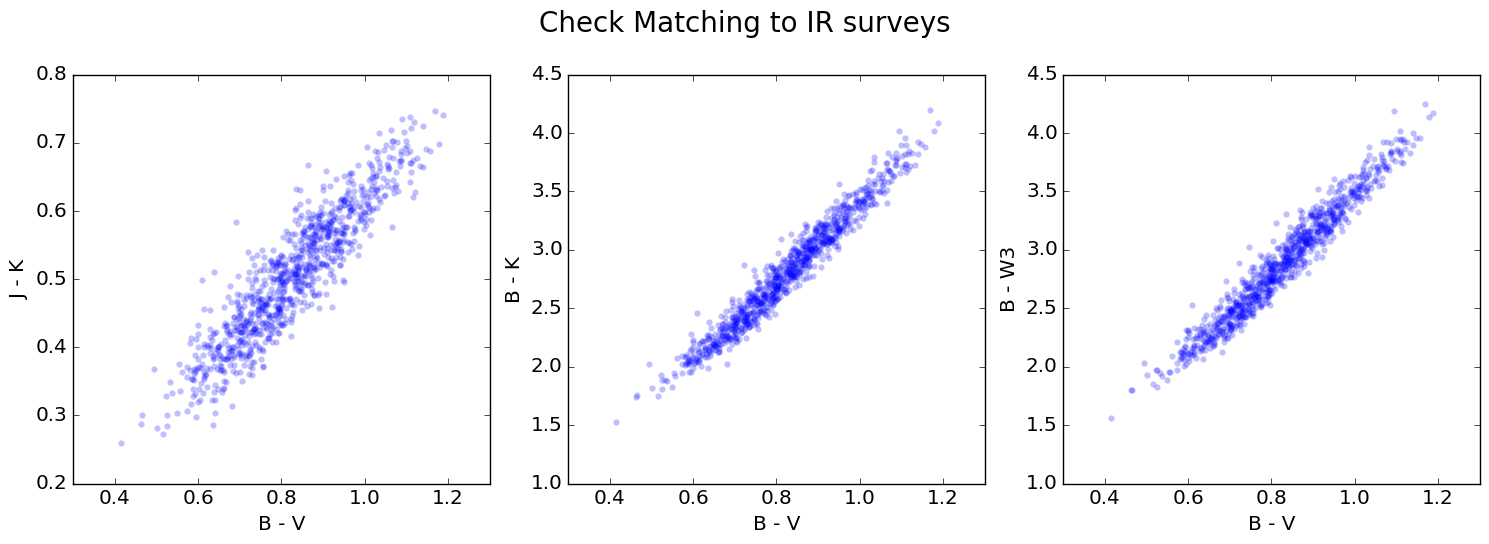

In [12]:
#add 2MASS and WISE (farther infrared)
#make color color plots to check outliers B-V J-K anamolies where stars are getting fucked up in matching 
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Check Matching to IR surveys', fontsize=20, y=1.08)
ax[0].scatter(magsMatched['bmag'] - magsMatched['vmag'], twoMassMatched['j_mag'] - twoMassMatched['k_mag'], alpha=0.25, lw=0)
ax[0].set_xlabel('B - V')
ax[0].set_ylabel('J - K')

ax[1].scatter(magsMatched['bmag'] - magsMatched['vmag'], magsMatched['bmag'] - twoMassMatched['k_mag'], alpha=0.25, lw=0)
ax[1].set_xlabel('B - V')
ax[1].set_ylabel('B - K')

ax[2].scatter(magsMatched['bmag'] - magsMatched['vmag'], magsMatched['bmag'] - wiseMatched['w3mpro'], alpha=0.25, lw=0)
ax[2].set_xlabel('B - V')
ax[2].set_ylabel('B - W3')


plt.tight_layout()
plt.savefig('IRmatchCheck.png')

In [13]:
if nNeighbors > np.sum(matched): nNeighbors = np.sum(matched)

In [14]:
distMatched = dist[matched]
medianDistMatched = np.median(distMatched, axis=1)
muMatched = 5. * np.log10(distMatched / 10.) # 10 pc is mu = 0
meanMuMatched = np.mean(muMatched, axis=1)
varMuMatched = np.mean((muMatched - meanMuMatched[:,None]) ** 2, axis=1)

In [15]:
#Assuming an R_V of 3.1, good assumption for Milky Way so say Schlafly+Finkbeiner
#include dust, narrower correlations, B-K 
#add wrong sign 
#look for precomputed attenuation for bandpasses 
#check that sign is correct
B_RedCoeff = 3.626
V_RedCoeff = 2.742
g_RedCoeff = 3.303
r_RedCoeff = 2.285
i_RedCoeff = 1.698

//anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:3578: RuntimeWarning: Invalid value encountered in median for 600 results
  RuntimeWarning)
//anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:3578: RuntimeWarning: Invalid value encountered in median for 18600 results
  RuntimeWarning)
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in greater
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:25: RuntimeWarning: invalid value encountered in greater


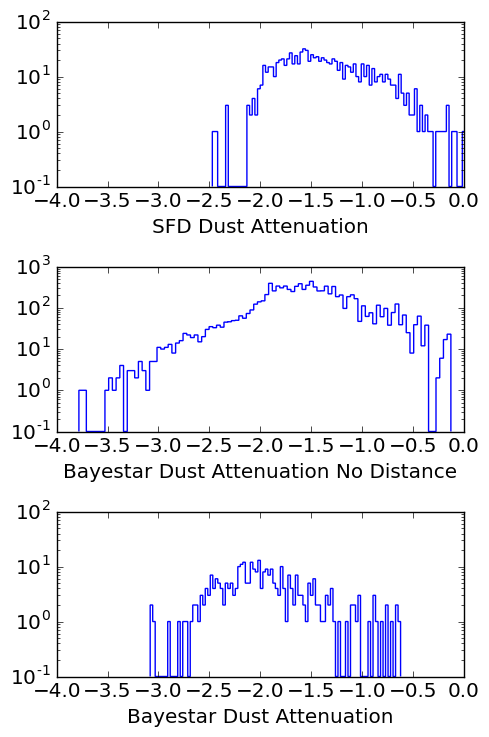

In [16]:
#include dust
from dustmaps.sfd import SFDQuery
from dustmaps.bayestar import BayestarQuery
from astropy.coordinates import SkyCoord
import astropy.units as units
sfd = SFDQuery()
bayes = BayestarQuery(max_samples=2)
c = SkyCoord(
        tgasMatched['l']*units.deg,
        tgasMatched['b']*units.deg,
        distance = medianDistMatched*units.pc,
        frame='galactic')
cNoDist = SkyCoord(
        tgasMatched['l']*units.deg,
        tgasMatched['b']*units.deg,
        frame='galactic')

bayesDust = bayes(c, mode='median')
bayesDustNoDist = bayes(cNoDist, mode='median')

fig, ax = plt.subplots(3, figsize=(5, 7.5))

ax[0].hist(np.log10(sfd(c)), bins=100, log=True, histtype='step')
ax[1].hist(np.log10(bayesDustNoDist[bayesDustNoDist>0]), bins=100, log=True, histtype='step')
ax[2].hist(np.log10(bayesDust[bayesDust >0]), bins=100, log=True, histtype='step')

ax[0].set_xlabel('SFD Dust Attenuation')
ax[1].set_xlabel('Bayestar Dust Attenuation No Distance')
ax[2].set_xlabel('Bayestar Dust Attenuation')
for a in ax: a.set_xlim(-4, 0.0)
plt.tight_layout()

In [17]:
np.sum(np.isnan(bayesDust))

600

11.9964 11.9703 [ 0.30298319  0.28681988  0.03379282  0.          0.          0.          0.
  0.          0.          0.00982541  0.00883106  0.02365096  0.0110584
  0.02318439  0.          0.02055647  0.0187046   0.02463741  0.0156458
  0.0335715   0.01842082  0.0164806   0.03679995  0.01040443  0.01925342
  0.01733886  0.01916821  0.02490729  0.01210894  0.03083551  0.02119975
  0.02925592  0.01382055  0.04143055  0.01447237  0.01475724  0.01216247
  0.01218318  0.02111139  0.02932454  0.01486053  0.0311828   0.02256409
  0.02524046  0.02571798  0.03076032  0.01356787  0.01411724  0.01785108
  0.00326729  0.01844038  0.04370774  0.0244321   0.02342493  0.04000485
  0.00304232  0.03908556  0.16316558  0.00872806  0.02370883  0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.01773399  0.02982928  0.02026781  0.02229384  0.02991591
  0.03905339  0.01848636  0.0223384   0.01052574  0.01548993  0.01680021
  0.02252913  0.00800223 

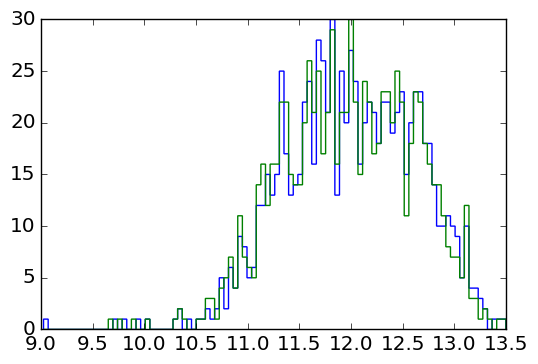

In [18]:
#!!!!! Do something else than setting it equal to 0 !!!!! 
bayesDust[np.isnan(bayesDust)] = 0.0
hist, bins = np.histogram(magsMatched['bmag'], bins=100)
plt.hist(magsMatched['bmag'], bins=bins, histtype='step')
plt.hist(magsMatched['bmag'] - B_RedCoeff*bayesDust, bins=bins, histtype='step')
print np.mean(magsMatched['bmag']), np.mean(magsMatched['bmag'] - B_RedCoeff*bayesDust), B_RedCoeff*bayesDust

In [19]:
#B_RedCoeff*bayesDust
M_V = magsMatched['vmag'] - V_RedCoeff*bayesDust - meanMuMatched
B_V = magsMatched['bmag'] - B_RedCoeff*bayesDust - (magsMatched['vmag'] - V_RedCoeff*bayesDust)
g_r = magsMatched['gmag'] - g_RedCoeff*bayesDust - (magsMatched['rmag'] - r_RedCoeff*bayesDust)
r_i = magsMatched['rmag'] - r_RedCoeff*bayesDust - (magsMatched['imag'] - i_RedCoeff*bayesDust)

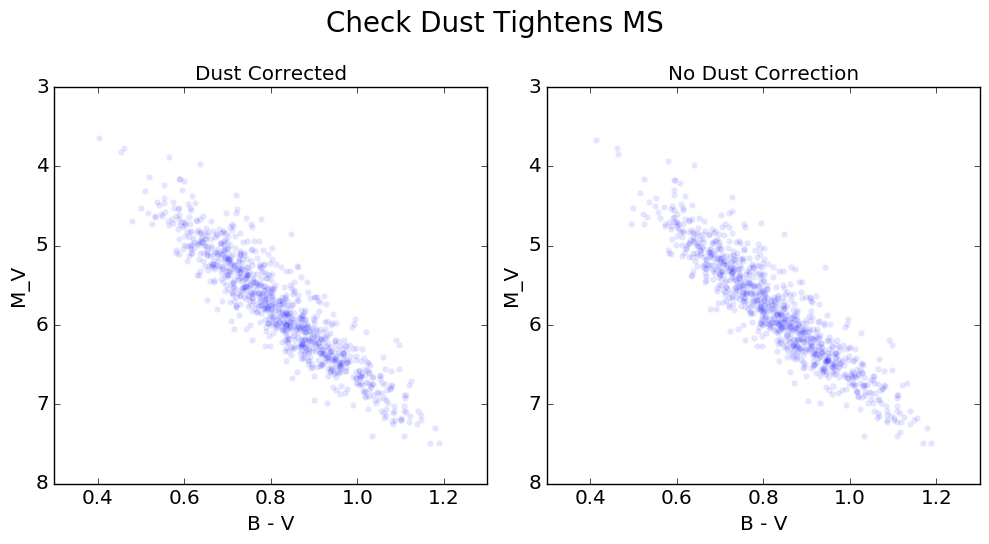

In [20]:
#check dust tightens main sequence 
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Check Dust Tightens MS', fontsize=20, y=1.08)
ax[0].scatter(B_V, M_V, alpha=0.1, lw=0)
ax[0].set_xlabel('B - V')
ax[0].set_ylabel('M_V')
ax[0].set_title('Dust Corrected')
ax[0].invert_yaxis()

ax[1].scatter(magsMatched['bmag'] - magsMatched['vmag'], magsMatched['vmag'] - meanMuMatched, alpha=0.1, lw=0)
ax[1].set_xlabel('B - V')
ax[1].set_ylabel('M_V')
ax[1].set_title('No Dust Correction')
ax[1].invert_yaxis()
plt.tight_layout()
plt.savefig('dustCorrected.png')

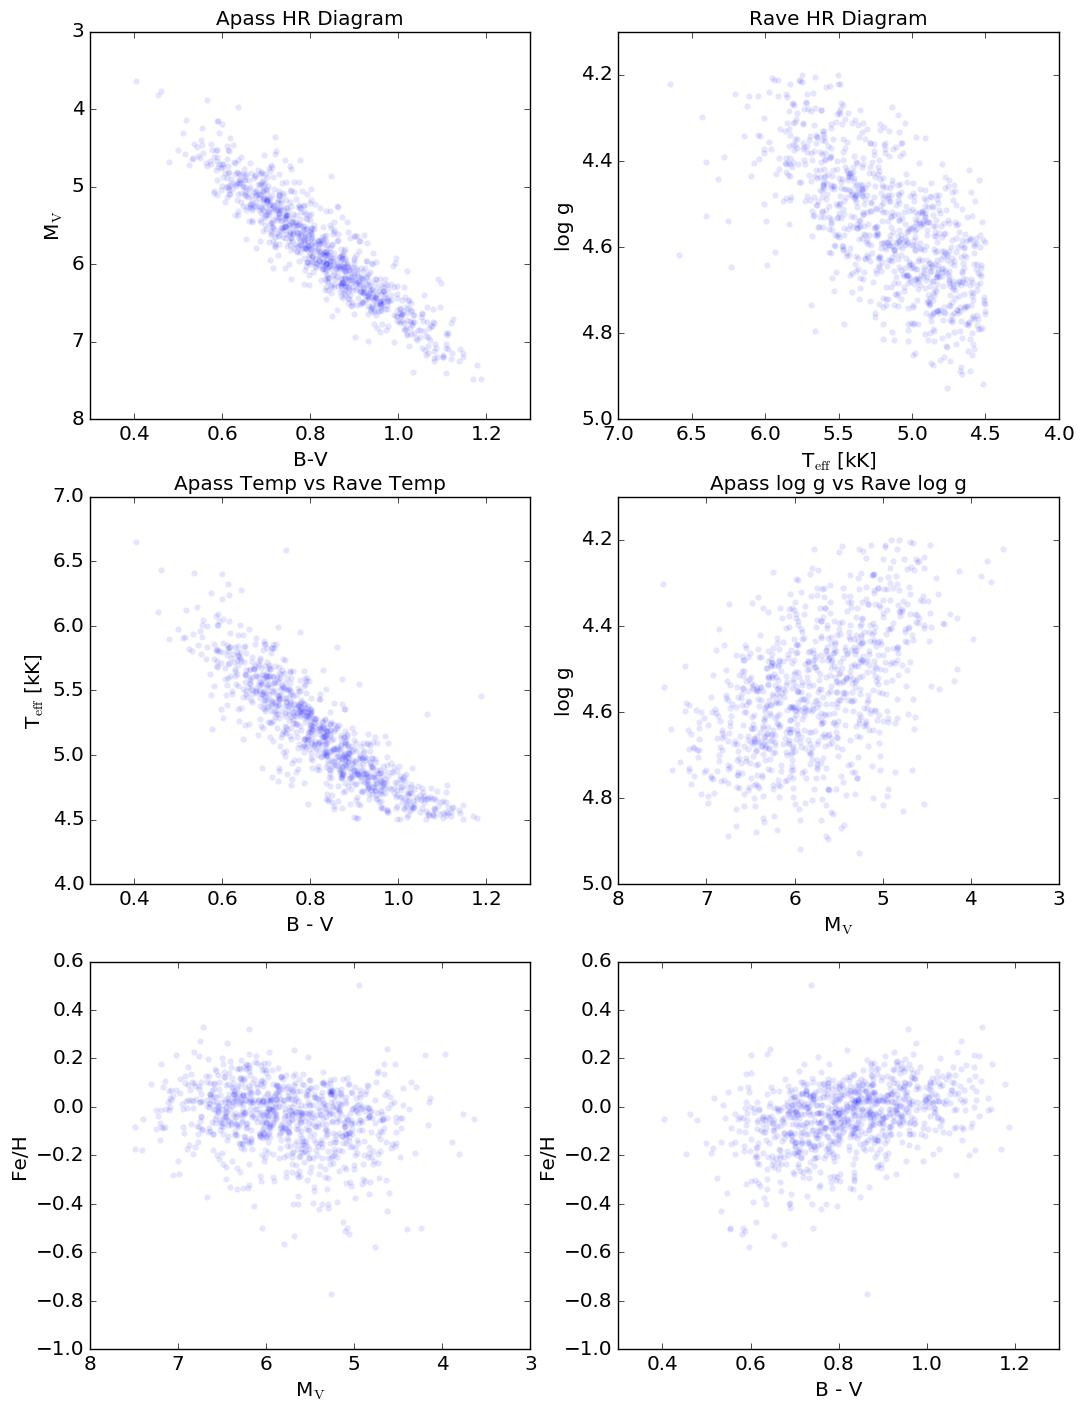

In [21]:
# plot all stars under consideration 
alpha = 0.1
fig, axes = plt.subplots(3,2, figsize=(12.5, 17))
axes = axes.flatten()
axes[0].scatter(B_V,M_V, alpha=alpha, lw=0)
axes[0].invert_yaxis()
axes[0].set_xlabel('B-V')
axes[0].set_ylabel('M$_\mathrm{V}$')
axes[0].set_title('Apass HR Diagram')

axes[1].scatter(raveMatched['TEFF']/1000., raveMatched['LOGG'], alpha=alpha, lw=0)
axes[1].invert_yaxis()
axes[1].invert_xaxis()
axes[1].set_xlabel('T$_\mathrm{eff}$ [kK]')
axes[1].set_ylabel('log g')
axes[1].set_title('Rave HR Diagram')

axes[2].scatter(B_V, raveMatched['TEFF']/1000., alpha=alpha, lw=0)
#axes[2].invert_xaxis()
axes[2].set_ylabel('T$_\mathrm{eff}$ [kK]')
axes[2].set_xlabel('B - V')
axes[2].set_title('Apass Temp vs Rave Temp')

axes[3].scatter(M_V, raveMatched['LOGG'], alpha=alpha, lw=0)
axes[3].set_xlabel('M$_\mathrm{V}$')
axes[3].set_ylabel('log g')
axes[3].invert_yaxis()
axes[3].invert_xaxis()
axes[3].set_title('Apass log g vs Rave log g')

axes[4].scatter(M_V, raveMatched['FE_H'], alpha=alpha, lw=0)
axes[4].invert_xaxis()
axes[4].set_xlabel('M$_\mathrm{V}$')
axes[4].set_ylabel('Fe/H')


axes[5].scatter(B_V, raveMatched['FE_H'], alpha=alpha, lw=0)
#axes[5].invert_xaxis()
axes[5].set_xlabel('B - V')
axes[5].set_ylabel('Fe/H')
plt.savefig('AllStarsMatched.png')

In [22]:
treeColor = kdtree.cKDTree(data=zip(M_V, B_V, g_r, r_i))

In [23]:
treeRave = kdtree.cKDTree(data=zip(M_V, B_V, g_r, r_i, raveMatched['LOGG'], raveMatched['TEFF']))

In [24]:
#some magsMatched[matchedInd, sourceInd] have 0.0 error :/

def distMetric(sourceInd, matchedInd, apassMagnitudes, p=False):
    colorChiSq = 0.0
    colorSigs = 0.0
    colors = [B_V, g_r, r_i]
    color_errors = [['e_bmag', 'e_vmag'], ['e_gmag', 'e_rmag'], ['e_rmag', 'e_imag']]
    for color, error in zip(colors, color_errors):
        #print mag, error, sourceInd, matchedInd
        colorChiSq += (color[sourceInd] - color[matchedInd])**2./\
                      (apassMagnitudes[error[0]][sourceInd]**2. + apassMagnitudes[error[1]][sourceInd]**2. + \
                       apassMagnitudes[error[0]][matchedInd]**2.+ apassMagnitudes[error[1]][matchedInd]**2.)
        colorSigs += np.log(apassMagnitudes[error[0]][matchedInd]**2. + apassMagnitudes[error[1]][matchedInd]**2. + \
                           apassMagnitudes[error[0]][sourceInd]**2. + apassMagnitudes[error[1]][sourceInd]**2.)
    absMagChiSq = (M_V[sourceInd] - M_V[matchedInd])**2./\
                  (magsMatched['e_vmag'][sourceInd]**2. + magsMatched['e_vmag'][matchedInd]**2. +\
                   varMuMatched[sourceInd] + varMuMatched[matchedInd])
    absMagSigs = np.log(magsMatched['e_vmag'][sourceInd]**2. + magsMatched['e_vmag'][matchedInd]**2. +\
                   varMuMatched[sourceInd] + varMuMatched[matchedInd])
    totChiSq = colorChiSq + absMagChiSq + colorSigs + absMagSigs
    if p:
        print 'the total chi2: ',totChiSq[0:5]
        print 'the color chi2: ',colorChiSq[0:5]
        print 'the color sigs: ', colorSigs[0:5]
        print 'the absmag chi2:',absMagChiSq[0:5]
        print 'the absmag sigs:',absMagSigs[0:5]
    #if np.sum(np.isinf(totChiSq)): pdb.set_trace()
    return totChiSq

In [25]:
def findNeighborsAndCalculateChisqs(sourceIndex, pts, tree, apassMagnitudes, nNeighbors=200, printChi=False):
    treeDistNum, treeIndex = tree.query(pts, k=nNeighbors)
    treeIndNum = treeIndex[1:]
    chisq = distMetric(sourceIndex, treeIndNum, apassMagnitudes, p=printChi)
    return chisq, treeIndNum

In [26]:
#check ChiSq are what you think they are, correct length, why inf?
nstars = np.sum(matched)
nydim = nNeighbors

#if nstars < nNeighbors: nydim = nstars
sources = np.zeros(nstars, dtype='int32')
matches = np.zeros((nstars, nydim-1), dtype='int32')
#chisqThreshold = 100
chisqApass = np.zeros((nstars, nydim-1))
for star in np.arange(nstars):
    pts = [M_V[star], B_V[star], g_r[star], r_i[star]]
    chisq, treeIndex = findNeighborsAndCalculateChisqs(star, pts, treeColor, magsMatched, nNeighbors=nNeighbors, printChi=False)
    sort = np.argsort(treeIndex)
    chisq = chisq[sort]
    treeIndex = treeIndex[sort]
    chisqApass[star,:] = chisq #don't include self, zero is closest
    #treeIndex = treeIndex[chisq < chisqThreshold]
    sources[star] = star
    matches[star,:] = treeIndex

In [27]:
print np.shape(chisqApass), len(chisq), nstars

(904, 903) 903 904


In [28]:
def raveChisq(sourceInd, matchesInd):
    chisq = (raveMatched['TEFF'][sourceInd] - raveMatched['TEFF'][matchesInd])**2./(raveMatched['E_TEFF'][sourceInd]**2. + raveMatched['E_TEFF'][matchesInd]**2.) + \
            (raveMatched['LOGG'][sourceInd] - raveMatched['LOGG'][matchesInd])**2./(raveMatched['E_LOGG'][sourceInd]**2. + raveMatched['E_LOGG'][matchesInd]**2.) + \
            (raveMatched['FE_H'][sourceInd] - raveMatched['FE_H'][matchesInd])**2./(raveMatched['E_FE_H'][sourceInd]**2. + raveMatched['E_FE_H'][matchesInd]**2.) + \
            np.log(raveMatched['E_TEFF'][sourceInd]**2. + raveMatched['E_TEFF'][matchesInd]**2.) + \
            np.log(raveMatched['E_LOGG'][sourceInd]**2. + raveMatched['E_LOGG'][matchesInd]**2.) + \
            np.log(raveMatched['E_FE_H'][sourceInd]**2. + raveMatched['E_FE_H'][matchesInd]**2.)
    return chisq
            

In [29]:
nstars = np.sum(matched)
raveSource = np.zeros(nstars, dtype='int32')
raveMatch = np.zeros((nstars, nydim-1), dtype='int32')
chisqRave = np.zeros((nstars, nydim-1))
for i, (s, m) in enumerate(zip(sources, matches)):
    raveStar = np.where(np.in1d(raveMatched['source_id'], tgasMatched[s]['source_id']))[0]
    raveTwins = np.where(np.in1d(raveMatched['source_id'], tgasMatched[m]['source_id']))[0]
    if np.sum(raveMatched['source_id'][raveTwins] - tgasMatched[m]['source_id']) != 0: print 'Rave not sorted like Apass'
    raveSource[i] = raveStar
    raveMatch[i, :] = raveTwins
    chisqRave[i, :] = raveChisq(raveStar, raveTwins)


In [30]:
def neff(weights):
    return np.sum(weights)**2./np.sum(weights**2.)

In [31]:
neffRave = np.zeros(nstars)
neffApass = np.zeros(nstars)
for i in range(nstars):
    neffRave[i] = neff(np.exp(-0.5*chisqRave[i]))
    neffApass[i] = neff(np.exp(-0.5*chisqApass[i]))

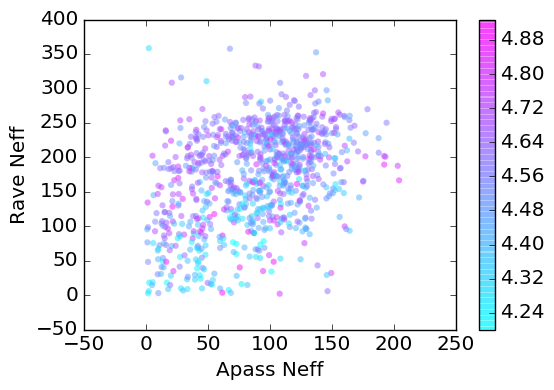

In [32]:
logg = raveMatched['LOGG'][raveSource]
#dwarfs = (logg < 5.) & (logg > 4.2) & (teff > 4500)
varpi = tgasMatched['parallax'][sources]
teff = raveMatched['TEFF'][raveSource]
#warm = teff > 4500
plt.scatter(neffApass, neffRave, lw=0, alpha=0.5, c=logg, norm=mpl.colors.Normalize(), cmap='cool')
plt.colorbar()
plt.xlabel('Apass Neff')
plt.ylabel('Rave Neff')

In [33]:
print 'Lots of Apass, few Rave: ', np.where((neffRave < 50.) & (neffApass > 100.))
print 'Few Apass, lots of Rave: ', np.where((neffRave > 150.) & (neffApass < 25.))

Lots of Apass, few Rave:  (array([ 29,  68, 142, 418, 622, 686, 795]),)
Few Apass, lots of Rave:  (array([ 49, 180, 284, 322, 365, 434, 482, 502, 526, 580, 597, 612, 649,
       660, 664, 680, 709, 714, 810, 817]),)


In [34]:
#spot check dwarfs with lots of Apass neighbors but few Rave neighbors 

In [35]:
print np.min(raveMatched['E_LOGG']), np.max(raveMatched['E_LOGG'])

0.122106603673 0.247776132382


In [36]:
print nstars

904


In [37]:
np.sum(raveMatched['source_id'][raveTwins] - tgasMatched[m]['source_id'][np.argsort(tgasMatched[m]['source_id'])])
argsort = np.argsort(tgasMatched[m]['source_id'])
raveInd = np.where(np.in1d(raveMatched['source_id'], tgasMatched[m]['source_id']))
print np.sum(tgasMatched[m]['source_id'][argsort] - raveMatched[raveInd]['source_id'])#[argsort]

0


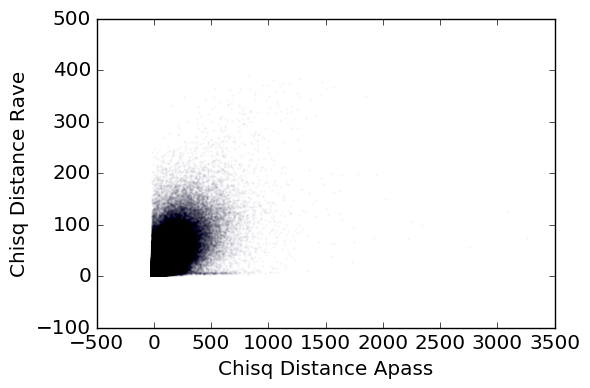

In [38]:
fig, ax = plt.subplots()
for chiA, chiR in zip(chisqApass, chisqRave):
    ax.scatter(chiA, chiR, alpha=0.01, s=1)
#ax.set_xlim(0, 10)
#ax.set_ylim(0, 15)
ax.set_xlabel('Chisq Distance Apass')
ax.set_ylabel('Chisq Distance Rave')
plt.tight_layout()
plt.savefig('chisqApassRaveUncorrelated.png')
plt.show()

In [39]:
def plotRainbows(axes, matchArrayIndex, vmax=5): 
    alpha_points = 0.3
    alpha_bars = 0.25
    vmax = 5

    b_v_lim = [0.25, 1.5]
    g_r_lim = None #[0, 1.5]

    r_i_lim = None #[-0.25, 0.75]
    M_v_lim = None #[10, 2]

    teff_lim = [7, 4] #kK
    log_g_lim = [6, 3] 


    twins = matches[matchArrayIndex, :]
    star = sources[matchArrayIndex]
    raveTwins = raveMatch[matchArrayIndex, :]
    raveStar = raveSource[matchArrayIndex]
    chiApass = chisqApass[matchArrayIndex, :]

    #plot B-V vs g-r for the source and twins 
    ax = axes[0]
    ax.set_title('Tycho2 ID: ' + tgasMatched['tycho2_id'][star])
    ax.scatter(g_r[twins], r_i[twins], c=chiApass - np.min(chiApass), cmap='plasma', 
               norm=mpl.colors.Normalize(vmax=vmax), lw=0, zorder=100, alpha=alpha_points)
    ax.errorbar(g_r[twins], r_i[twins], 
                xerr = np.sqrt(magsMatched['e_gmag'][twins]**2. + magsMatched['e_rmag'][twins]**2.), 
                yerr = np.sqrt(magsMatched['e_rmag'][twins]**2. + magsMatched['e_imag'][twins]**2.), 
                fmt="none", ecolor='black', zorder=0, lw=0.5, mew=0, alpha=alpha_bars)
    ax.errorbar(g_r[star], r_i[star], 
                xerr = np.sqrt(magsMatched['e_bmag'][star]**2. + magsMatched['e_vmag'][star]**2.), 
                yerr = np.sqrt(magsMatched['e_gmag'][star]**2. + magsMatched['e_rmag'][star]**2.), fmt='o', color='black',lw=4)

    ax.scatter(g_r[star], r_i[star], s=400, c='black')
    ax.set_xlabel('g - r')
    ax.set_ylabel('r - i')
    ax.set_xlim(g_r_lim)
    ax.set_ylim(r_i_lim)
    ax.grid()

    #plot r-i and M_v for the source and twins
    ax = axes[1]
    ax.scatter(B_V[twins], M_V[twins], c=chiApass - np.min(chiApass), cmap='plasma', 
               norm=mpl.colors.Normalize(vmax=vmax), lw=0, zorder=100, alpha=alpha_points)
    ax.errorbar(B_V[twins], M_V[twins], 
                xerr = np.sqrt(magsMatched['e_bmag'][twins]**2. + magsMatched['e_vmag'][twins]**2.), 
                yerr = np.sqrt(magsMatched['e_vmag'][twins]**2. + varMuMatched[twins]),
                fmt="none", ecolor='black', zorder=0, lw=0.5, mew=0, alpha=alpha_bars)
    ax.errorbar(B_V[star], M_V[star], 
                xerr = np.sqrt(magsMatched['e_bmag'][star]**2. + magsMatched['e_vmag'][star]**2.), 
                yerr = np.sqrt(magsMatched['e_vmag'][star]**2. + varMuMatched[star]), 
                fmt='o', color='black', lw=4)
    ax.scatter(B_V[star], M_V[star], s=400, c='black')
    ax.set_xlabel('B - V')
    ax.set_ylabel('M_V')
    ax.invert_yaxis()
    ax.set_xlim(b_v_lim)
    ax.set_ylim(M_v_lim)
    ax.grid()
    
    #plot Teff vs log g for the source and twins
    raveTeff = raveMatched['TEFF'][raveTwins]
    raveLogG = raveMatched['LOGG'][raveTwins]

    ax = axes[2]
    ax.scatter(raveTeff/1000., raveLogG, c=chiApass - np.min(chiApass), cmap='plasma', 
               norm=mpl.colors.Normalize(vmax=vmax), lw=0, zorder=100, alpha=alpha_points)
    ax.errorbar(raveTeff/1000., raveLogG, 
                xerr=raveMatched['E_TEFF'][raveTwins]/1000., yerr=raveMatched['E_LOGG'][raveTwins],
                fmt='none', ecolor='black', zorder=0, lw=0.5, mew=0, alpha=alpha_bars)
    ax.scatter(raveMatched['TEFF'][raveStar]/1000., raveMatched['LOGG'][raveStar], s=400, c='black')
    ax.errorbar(raveMatched['TEFF'][raveStar]/1000., raveMatched['LOGG'][raveStar], 
                xerr=raveMatched['E_TEFF'][raveStar]/1000., yerr=raveMatched['E_LOGG'][raveStar],
               fmt='o', color='black', lw=4)
    ax.set_ylabel('log g', fontsize=15)
    ax.set_xlabel('Teff [kK]', fontsize=15)
    ax.set_xlim(teff_lim)
    ax.set_ylim(log_g_lim)
    ax.grid()
    
    #plot B-V vs Fe/H for the source and twins 
    ax = axes[3]
    ax.errorbar(B_V[twins], raveMatched['FE_H'][raveTwins], yerr=raveMatched['E_FE_H'][raveTwins], 
              xerr = np.sqrt(magsMatched['e_bmag'][twins]**2. + magsMatched['e_vmag'][twins]**2.),
              fmt='none', ecolor='black', zorder=0, lw=0.5, mew=0, alpha=alpha_bars)
    ax.scatter(B_V[twins], raveMatched['FE_H'][raveTwins], c=chiApass - np.min(chiApass), cmap='plasma', 
               norm=mpl.colors.Normalize(vmax=vmax), lw=0, zorder=100, alpha=alpha_points)
    ax.scatter(B_V[star], raveMatched['FE_H'][raveStar], s=400, c='black')
    ax.errorbar(B_V[star], raveMatched['FE_H'][raveStar], yerr=raveMatched['E_FE_H'][raveStar], 
                xerr = np.sqrt(magsMatched['e_bmag'][star]**2. + magsMatched['e_vmag'][star]**2.), 
                fmt='o', color='black', lw=4)
    ax.set_xlabel('B - V', fontsize=15)
    ax.set_ylabel('[Fe/H]', fontsize=15)
    ax.grid()


In [40]:
#get K nearest neighbors k to star j in a photometry + gaia sense, for each jk pair we have X2jk
#each of the k neighbors has label vector l_k=[Teff_k, logg_k, Fe/H_k]
#posterior pdf for the rave laels for star j are: P(l_j|photometry) ~ sum_k(exp(-X2jk/2)*l_k) ?? k

In [41]:
def gaussian(mean, sigma, array, amplitude=None):
    if amplitude: 
        return amplitude*np.exp(-(array - mean)**2./(2.*sigma**2.))
    else:
        return 1./np.sqrt(2.*np.pi*sigma**2.)*\
                    np.exp(-(array - mean)**2./(2.*sigma**2.))

In [42]:
def pdf(mean, sigma, area, array):
    return np.sum(area/np.sqrt(2.*np.pi*sigma**2.)*\
                    np.exp(-(array - mean)**2./(2.*sigma**2.)), axis=1)

In [43]:
print neff(np.ones(6))
print neff(np.array([1, 1, 1, 0.001, 0.001, 0.001]))
print neff(np.array([1000, 1, 1, 1, 1, 1]))

6.0
3.005999994
1.0100199499


In [44]:
def plotPDFs(axes, matchArrayIndex):
    teff_prob = np.zeros(npoints)
    logg_prob = np.zeros(npoints)
    feh_prob = np.zeros(npoints)
    
    twins = matches[matchArrayIndex]
    star = sources[matchArrayIndex]
    raveTwins = raveMatch[matchArrayIndex]
    raveStar = raveSource[matchArrayIndex]
    chiApass = chisqApass[matchArrayIndex]

    #guassian weight for each twin 
    gaussianArea = np.exp(-chiApass/2.)
    neff = np.sum(gaussianArea)**2./np.sum(gaussianArea**2.)

    temp = raveMatched['TEFF'][raveTwins]
    temp_err = raveMatched['E_TEFF'][raveTwins]
    teff_pdf = pdf(temp, temp_err, gaussianArea, teff_array[:,None])
    
    logg = raveMatched['LOGG'][raveTwins]
    logg_err = raveMatched['E_LOGG'][raveTwins]
    logg_pdf = pdf(logg, logg_err, gaussianArea, logg_array[:,None])

    feh = raveMatched['FE_H'][raveTwins]
    feh_err = raveMatched['E_FE_H'][raveTwins]
    feh_pdf = pdf(feh, feh_err, gaussianArea, feh_array[:,None])
    
    ax = axes[0]
    ax.plot(teff_array/1000., teff_pdf/np.max(teff_pdf), lw=2, label='PDF', alpha=alpha)
    ax.set_title('{:.2e}'.format(neff))
    star_gauss = gaussian(raveMatched['TEFF'][raveStar], raveMatched['E_TEFF'][raveStar], teff_array)
    ax.plot(teff_array/1000., star_gauss/np.max(star_gauss), lw=2, label='RAVE', alpha=alpha)
    ax.set_ylim(0, 1.1)
    ax.set_xlabel('T$_\mathrm{eff}$ [kK]', fontsize=20)
    ax.legend()
    
    ax = axes[1]
    ax.plot(logg_array, logg_pdf/np.max(logg_pdf), lw=2, label='PDF', alpha=alpha)
    star_gauss = gaussian(raveMatched['LOGG'][raveStar], raveMatched['E_LOGG'][raveStar], logg_array)
    ax.plot(logg_array, star_gauss/np.max(star_gauss), lw=2, label='RAVE', alpha=alpha)
    ax.set_ylim(0, 1.1)
    ax.set_xlabel('log g')
    ax.legend()
    
    ax = axes[2]
    ax.plot(feh_array, feh_pdf/np.max(feh_pdf), lw=2, label='PDF', alpha=alpha)
    star_gauss = gaussian(raveMatched['FE_H'][raveStar], raveMatched['E_FE_H'][raveStar], feh_array)
    ax.plot(feh_array, star_gauss/np.max(star_gauss), lw=2, label='RAVE', alpha=alpha)
    ax.set_ylim(0, 1.1)
    ax.set_xlabel('Fe/H')
    ax.legend()   


In [45]:
#plot observed vs predicted 
alpha = 0.5
nplot=10
s = 10
lw=0
ylim = (0.1, 1e5)

npoints = 1000
teff_array = np.linspace(4000, 7000, npoints)
logg_array = np.linspace(3, 6, npoints)
feh_array  = np.linspace(-1.5, 1, npoints)

In [46]:
def draw_ellipse(mu, C, scales=[1, 2, 3], ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    # find principal components and rotation angle of ellipse
    sigma_x2 = C[0, 0]
    sigma_y2 = C[1, 1]
    sigma_xy = C[0, 1]
    print sigma_x2, sigma_y2, sigma_xy
    alpha = 0.5 * np.arctan2(2 * sigma_xy,
                             (sigma_x2 - sigma_y2))
    tmp1 = 0.5 * (sigma_x2 + sigma_y2)
    tmp2 = np.sqrt(0.25 * (sigma_x2 - sigma_y2) ** 2 + sigma_xy ** 2)
    print tmp1, tmp2
    sigma1 = np.sqrt(np.abs(tmp1 + tmp2))
    sigma2 = np.sqrt(np.abs(tmp1 - tmp2))
    print sigma1, sigma2
    for scale in scales:
        ax.add_patch(Ellipse((mu[0], mu[1]),
                             2 * scale * sigma1, 2 * scale * sigma2,
                             alpha * 180. / np.pi,
                             **kwargs))

In [47]:
def plotXD(axes, matchArrayIndex, ngauss=2):

    twins = matches[matchArrayIndex]
    star = sources[matchArrayIndex]
    raveTwins = raveMatch[matchArrayIndex]
    raveStar = raveSource[matchArrayIndex]
    chiApass = chisqApass[matchArrayIndex]

    amp_guess = np.zeros(ngauss) + 1.
    mean_guess = np.array([[4.5, 4.0, 0], [4.5, 3.5, 0]])

    temp = raveMatched['TEFF'][raveTwins]/1000.
    temp_err = raveMatched['E_TEFF'][raveTwins]/1000.

    logg = raveMatched['LOGG'][raveTwins]
    logg_err = raveMatched['E_LOGG'][raveTwins]

    feh = raveMatched['FE_H'][raveTwins]
    feh_err = raveMatched['E_FE_H'][raveTwins]

    chiApass = chisqApass[matchArrayIndex]
    gaussianArea = np.exp(-chiApass/2.)

    X = np.vstack([temp, logg, feh]).T
    Xerr = np.zeros(X.shape + X.shape[-1:])
    diag = np.arange(X.shape[-1])
    Xerr[:,diag,diag] = np.vstack([temp_err**2., logg_err**2., feh_err**2.]).T

    cov_guess = np.zeros(((ngauss,) + X.shape[-1:] + X.shape[-1:]))
    cov_guess[:,diag,diag] = 1.0

    ed(X, Xerr, amp_guess, mean_guess, cov_guess, weight=gaussianArea)

    #clf = XDGMM(2)
    #clf.fit(X, Xerr)
    #sample = clf.sample(1000)
    if axes:
        print 'axes is ', axes
        for j, array in enumerate([teff_array/1000., logg_array, feh_array]):
            for i in np.arange(ngauss):
                gaussianModel = gaussian(mean_guess[i][j], np.sqrt(cov_guess[i][j,j]), array, amplitude=amp_guess[i])
                #axes[j].plot(array, gaussianModel, color='black', linestyle='--')
    return amp_guess, mean_guess, cov_guess

In [59]:
def plotXD2d(ax, matchArrayIndex, mean, cov, ngauss=2, fracMaxPlot=0.01, size=50, alpha_points=1., alpha_ellipse=1.):
    twins = matches[matchArrayIndex]
    star = sources[matchArrayIndex]
    raveTwins = raveMatch[matchArrayIndex]
    raveStar = raveSource[matchArrayIndex]
    chiApass = chisqApass[matchArrayIndex]

    temp = raveMatched['TEFF'][raveTwins]/1000.
    temp_err = raveMatched['E_TEFF'][raveTwins]/1000.

    logg = raveMatched['LOGG'][raveTwins]
    logg_err = raveMatched['E_LOGG'][raveTwins]

    feh = raveMatched['FE_H'][raveTwins]
    feh_err = raveMatched['E_FE_H'][raveTwins]

    chiApass = chisqApass[matchArrayIndex]
    gaussianArea = np.exp(-chiApass/2.)
    
    weighty = gaussianArea > fracMaxPlot*np.max(gaussianArea)

    X = np.vstack([temp, logg, feh]).T
    ax[0].set_title(neff(gaussianArea))
    ax[0].scatter(X[:,0][weighty], X[:,1][weighty], cmap='plasma_r', c = gaussianArea[weighty],
               norm=mpl.colors.Normalize(), lw=0, zorder=100, alpha=alpha_points,s=size)
    ax[0].errorbar(raveMatched['TEFF'][raveStar]/1000., raveMatched['LOGG'][raveStar], 
                  xerr=raveMatched['E_TEFF'][raveStar]/1000., yerr=raveMatched['E_LOGG'][raveStar],fmt='o',lw=2, zorder=100)
    for scale, alpha in zip([1, 2], [1.0, 0.5]):
        for i in range(ngauss):
            draw_ellipse(mean[i][0:2], cov[i][0:2], scales=[scale], ax=ax[0],
                 ec='k', fc='white', alpha=alpha_ellipse)

    ax[1].scatter(X[:,0][weighty], X[:,2][weighty], cmap='plasma_r', c = gaussianArea[weighty],
               norm=mpl.colors.Normalize(), lw=0, zorder=100, alpha=alpha_points, s=size)
    ax[1].errorbar(raveMatched['TEFF'][raveStar]/1000., raveMatched['FE_H'][raveStar], 
                  xerr=raveMatched['E_TEFF'][raveStar]/1000., yerr=raveMatched['E_FE_H'][raveStar],fmt='o',lw=2, zorder=100)

    for scale, alpha in zip([1, 2], [1.0, 0.5]):
        for i in range(ngauss):
            draw_ellipse(mean[i][[0,2]], cov[i][[0,2]], scales=[scale], ax=ax[1],
                 ec='k', fc='white', alpha=alpha_ellipse)

    ax[2].scatter(X[:,1][weighty], X[:,2][weighty], cmap='plasma_r', c = gaussianArea[weighty],
               norm=mpl.colors.Normalize(), lw=0, zorder=100, alpha=alpha_points, s=size)
    ax[2].errorbar(raveMatched['LOGG'][raveStar], raveMatched['FE_H'][raveStar], 
                  xerr=raveMatched['E_LOGG'][raveStar], yerr=raveMatched['E_FE_H'][raveStar],fmt='o',lw=2, zorder=100)

    for scale, alpha in zip([1, 2], [1.0, 0.5]):
        for i in range(ngauss):
            draw_ellipse(mean[i][1:3], cov[i][1:3], scales=[scale], ax=ax[2],
                 ec='k', fc='white', alpha=alpha_ellipse)

    ax[0].set_xlim(teff_lim)
    ax[0].set_xlabel('T$_\mathrm{eff}$')
    ax[1].set_xlim(teff_lim)
    ax[1].set_xlabel('T$_\mathrm{eff}$')
    ax[2].set_xlim(log_g_lim)
    ax[2].set_xlabel('log g')
    ax[0].set_ylim(log_g_lim)
    ax[0].set_ylabel('log g')
    ax[1].set_ylim(feh_lim)
    ax[1].set_ylabel('Fe/H')
    ax[2].set_ylim(feh_lim)
    ax[2].set_ylabel('Fe/H')
    plt.tight_layout()

In [60]:
"""
nplot = 10
fig, axes = plt.subplots(nplot, 7, figsize=(30, nplot*5))
#axes = itertools.cycle(axes.ravel())
plotNumber = 0
j = 0
#for j in randarray:
while plotNumber < nplot:
    try: 
        raveStar = raveSource[j]
        if raveMatched['LOGG'][raveStar] <=3.7:
            plotRainbows(axes[plotNumber][0:4], j, vmax=20)
            plotPDFs(axes[plotNumber][4:7], j)
            amp, mean, cov = plotXD(axes[plotNumber][4:7], j)
            plotNumber +=1
        j+=1
    except IndexError:
        print 'Not Enough Giants in Sample'
        plotNumber = nplot + 10
fig.suptitle('Rave "Giants"', y=1.01, fontsize=30)
plt.tight_layout()
plt.savefig('PDFvsRAVE_giants.png')
"""

'\nnplot = 10\nfig, axes = plt.subplots(nplot, 7, figsize=(30, nplot*5))\n#axes = itertools.cycle(axes.ravel())\nplotNumber = 0\nj = 0\n#for j in randarray:\nwhile plotNumber < nplot:\n    try: \n        raveStar = raveSource[j]\n        if raveMatched[\'LOGG\'][raveStar] <=3.7:\n            plotRainbows(axes[plotNumber][0:4], j, vmax=20)\n            plotPDFs(axes[plotNumber][4:7], j)\n            amp, mean, cov = plotXD(axes[plotNumber][4:7], j)\n            plotNumber +=1\n        j+=1\n    except IndexError:\n        print \'Not Enough Giants in Sample\'\n        plotNumber = nplot + 10\nfig.suptitle(\'Rave "Giants"\', y=1.01, fontsize=30)\nplt.tight_layout()\nplt.savefig(\'PDFvsRAVE_giants.png\')\n'

49
0.000666280807207 0.000713570877267 -0.000677148926914
0.000689925842237 0.000677561625908
0.0369795547316 0.00351627876162
4.10815167208e-07 1.11715398081e-06 -1.50140706069e-10
7.6398457401e-07 3.53169438716e-07
0.00105695506656 0.000640948621415
0.000666280807207 0.000713570877267 -0.000677148926914
0.000689925842237 0.000677561625908
0.0369795547316 0.00351627876162
4.10815167208e-07 1.11715398081e-06 -1.50140706069e-10
7.6398457401e-07 3.53169438716e-07
0.00105695506656 0.000640948621415
0.000666280807207 -0.00119894512554 -0.000677148926914
-0.000266332159166 0.00115251794531
0.0297688727725 0.0376676267434
4.10815167208e-07 -5.54760775474e-11 -1.50140706069e-10
2.05379845565e-07 2.05435376507e-07
0.000640948689111 7.4519086204e-06
0.000666280807207 -0.00119894512554 -0.000677148926914
-0.000266332159166 0.00115251794531
0.0297688727725 0.0376676267434
4.10815167208e-07 -5.54760775474e-11 -1.50140706069e-10
2.05379845565e-07 2.05435376507e-07
0.000640948689111 7.4519086204e-06

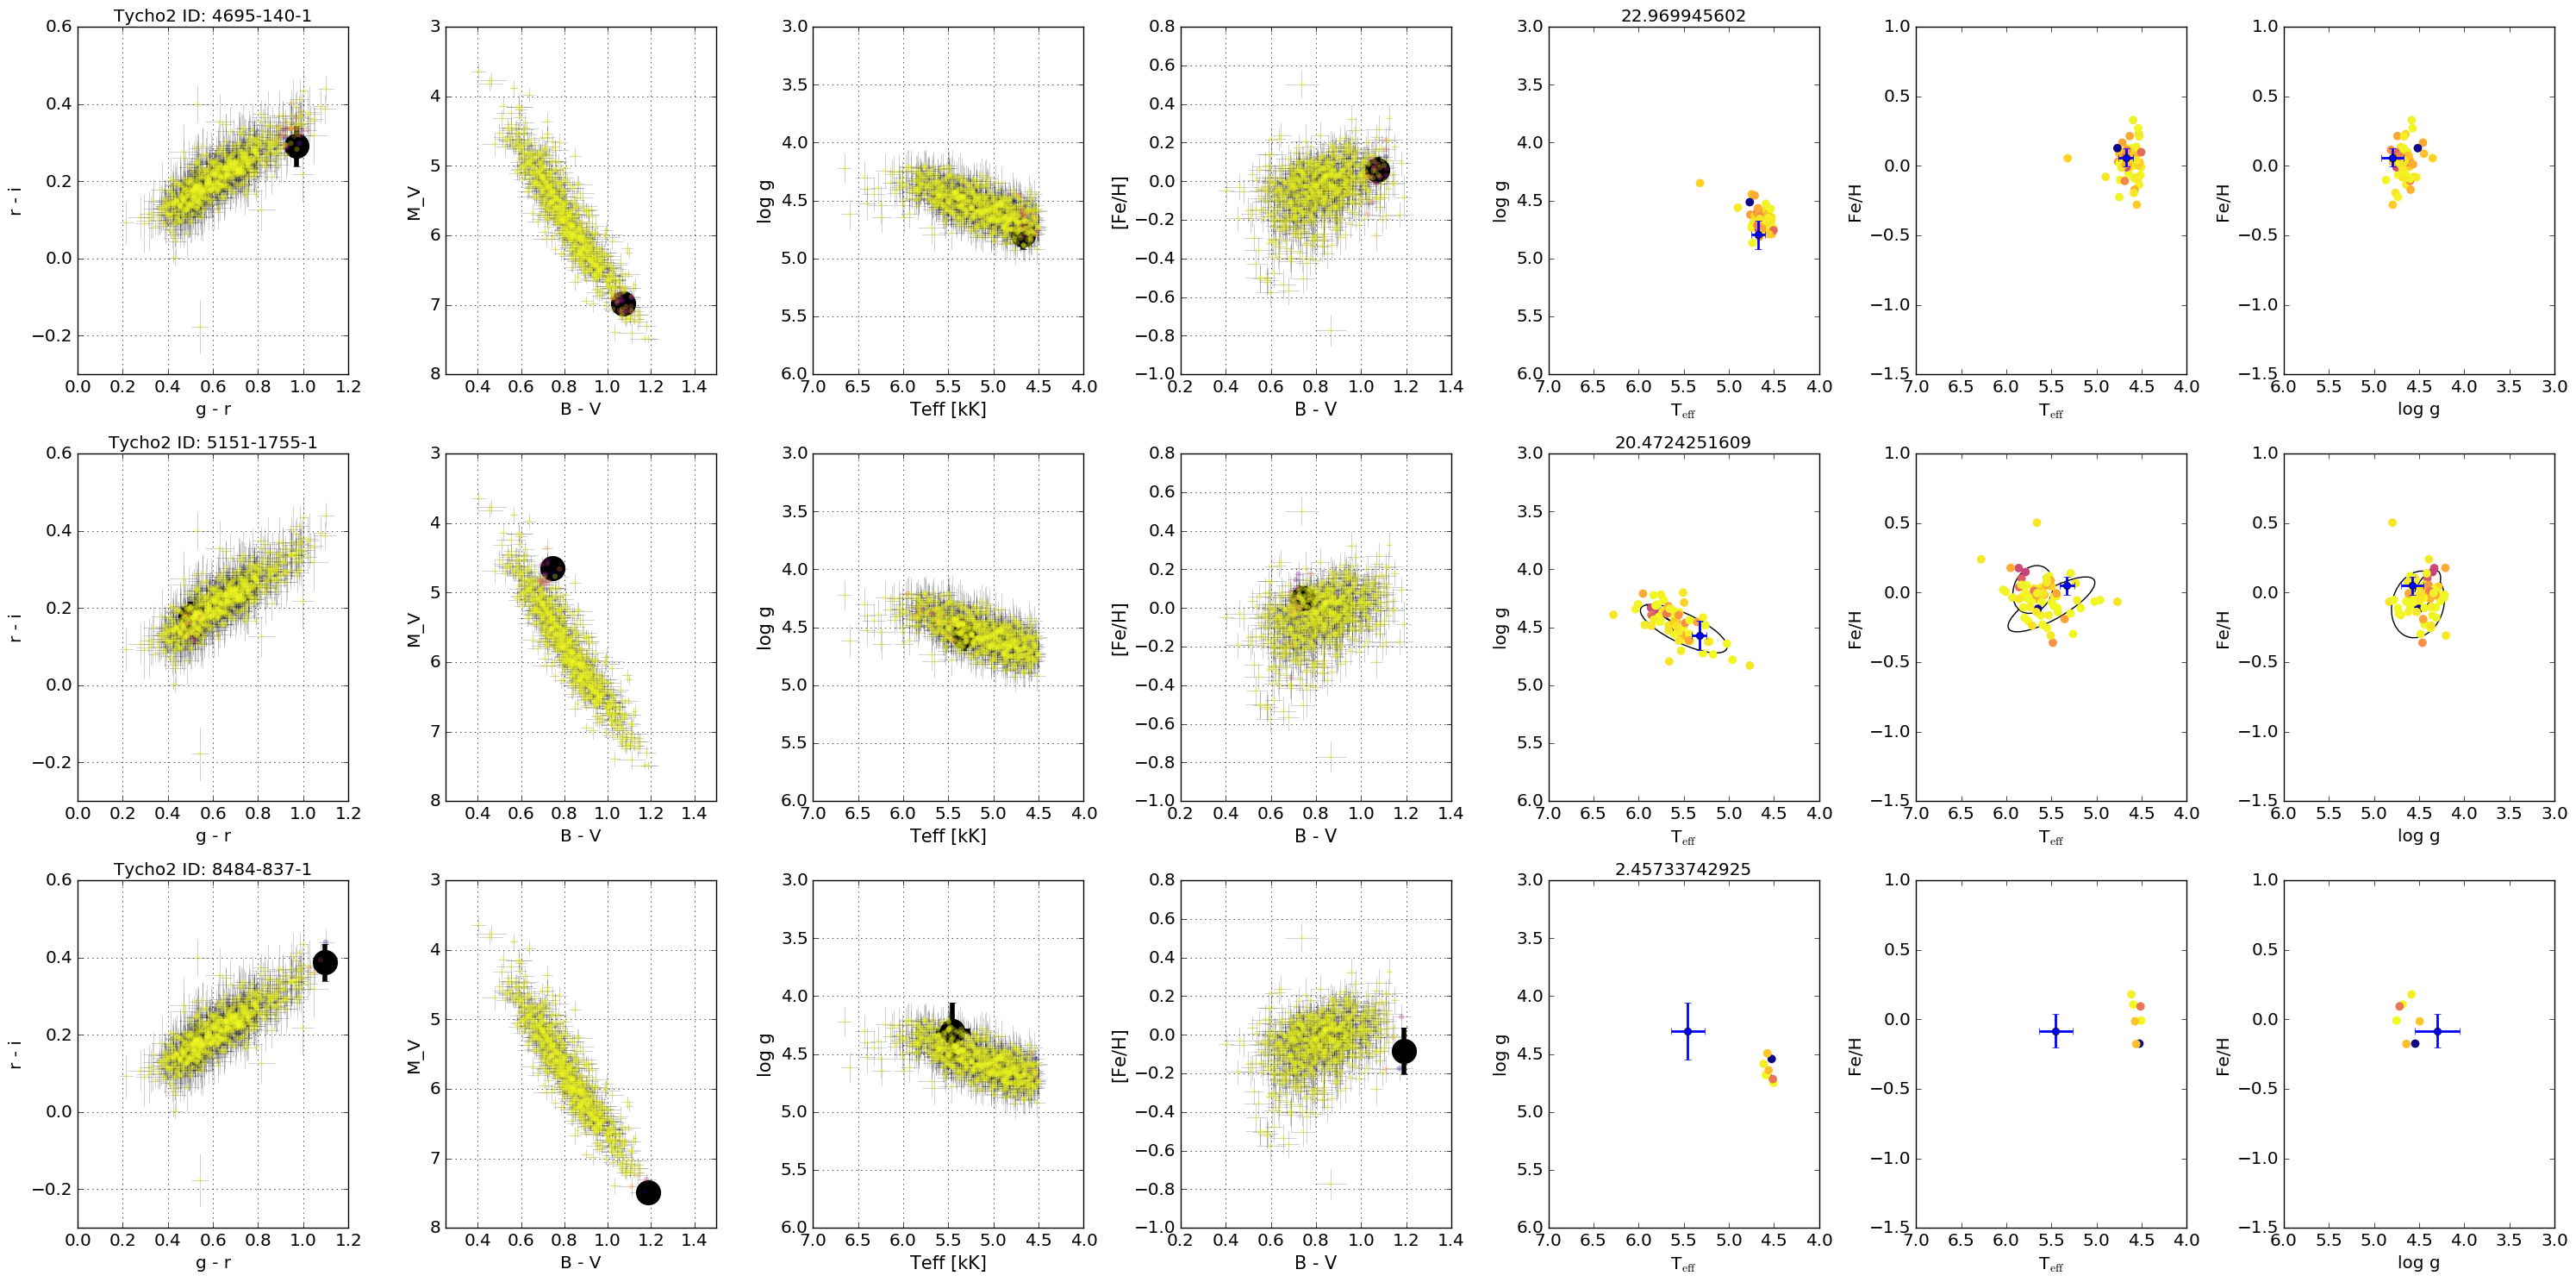

In [61]:
randarray = [ 49, 180, 284] #, 322, 365, 434] #, 482, 502, 526, 580, 597, 612, 649, 660, 664, 680, 709, 714, 810, 817] #[ 29,  68, 142, 418, 622, 686, 795]
nplot = len(randarray)
fig, axes = plt.subplots(nplot, 7, figsize=(30, nplot*5))
#axes = itertools.cycle(ax.ravel())
alpha_points = 0.3
alpha_bars = 0.25
vmax = 5

b_v_lim = [0.25, 1.5]
g_r_lim = None #[0, 1.5]

r_i_lim = None #[-0.25, 0.75]
M_v_lim = None #[10, 2]

teff_lim = [7, 4] #kK
log_g_lim = [6, 3] 
feh_lim = [-1.5, 1]
#randarray = np.random.randint(0, high=len(sources), size=nplot)
#randarray = randarray[np.argsort(M_V[sources][randarray])]

plotNumber = 0
for j in randarray:
    print j
    plotRainbows(axes[plotNumber][0:4], j, vmax=10)
    #plotPDFs(axes[plotNumber][4:7], j)
    amp, mean, cov = plotXD(None, j)
    plotXD2d(axes[plotNumber][4:7], j, mean, cov, ngauss=2, fracMaxPlot=0.01)
    plotNumber += 1

plt.tight_layout()
plt.savefig('manyRaveFewApass.png')

8.68803196931e-07 2.68828671979e-06 -3.50025914271e-07
1.77854495836e-06 9.74755463257e-07
0.00165930721134 0.00089654308045
7.45488908083e-07 1.93696535634e-06 1.08492572903e-08
1.34122713221e-06 5.95837006294e-07
0.00139178451583 0.000863359789378
8.68803196931e-07 2.68828671979e-06 -3.50025914271e-07
1.77854495836e-06 9.74755463257e-07
0.00165930721134 0.00089654308045
7.45488908083e-07 1.93696535634e-06 1.08492572903e-08
1.34122713221e-06 5.95837006294e-07
0.00139178451583 0.000863359789378
8.68803196931e-07 3.13320504368e-07 -3.50025914271e-07
5.9106185065e-07 4.46831507501e-07
0.001018770513 0.000379776701693
7.45488908083e-07 -1.11215679802e-07 1.08492572903e-08
3.1713661414e-07 4.28489666281e-07
0.000863496543375 0.000333696047535
8.68803196931e-07 3.13320504368e-07 -3.50025914271e-07
5.9106185065e-07 4.46831507501e-07
0.001018770513 0.000379776701693
7.45488908083e-07 -1.11215679802e-07 1.08492572903e-08
3.1713661414e-07 4.28489666281e-07
0.000863496543375 0.000333696047535
-3

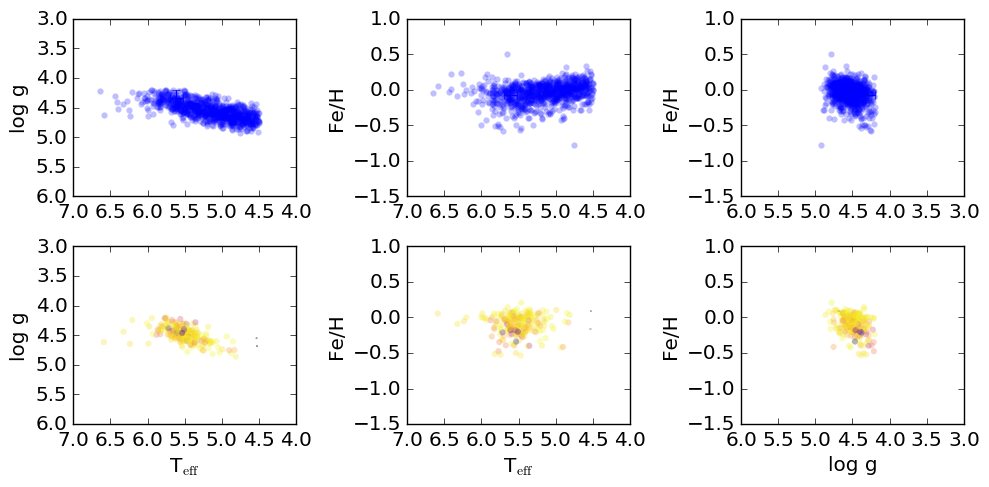

In [51]:
#errorbar rave point on top 
matchArrayIndex = 15
ngauss=2
twins = matches[matchArrayIndex]
star = sources[matchArrayIndex]
raveTwins = raveMatch[matchArrayIndex]
raveStar = raveSource[matchArrayIndex]
chiApass = chisqApass[matchArrayIndex]

temp = raveMatched['TEFF'][raveTwins]/1000.
temp_err = raveMatched['E_TEFF'][raveTwins]/1000.

temp_star = raveMatched['TEFF'][raveStar]
temp_err_star = raveMatched['E_TEFF'][raveStar]

logg = raveMatched['LOGG'][raveTwins]
logg_err = raveMatched['E_LOGG'][raveTwins]

logg_star = raveMatched['LOGG'][raveStar]
logg_star_err = raveMatched['E_LOGG'][raveStar]

feh = raveMatched['FE_H'][raveTwins]
feh_err = raveMatched['E_FE_H'][raveTwins]

chiApass = chisqApass[matchArrayIndex]
gaussianArea = np.exp(-chiApass/2.)

weighty = gaussianArea > 0.01*np.max(gaussianArea)

X = np.vstack([temp, logg, feh]).T


fig, ax = plt.subplots(2, 3, figsize=(10, 5))
ax[0, 0].scatter(X[:,0], X[:,1], alpha=0.25, lw=0)
ax[0, 0].errorbar(raveMatched['TEFF'][raveStar]/1000., raveMatched['LOGG'][raveStar], 
                  xerr=raveMatched['E_TEFF'][raveStar]/1000., yerr=raveMatched['E_LOGG'][raveStar])

ax[0, 1].scatter(X[:,0], X[:,2], alpha=0.25, lw=0)
ax[0, 1].errorbar(raveMatched['TEFF'][raveStar]/1000., raveMatched['FE_H'][raveStar], 
                  xerr=raveMatched['E_TEFF'][raveStar]/1000., yerr=raveMatched['E_FE_H'][raveStar])

ax[0, 2].scatter(X[:,1], X[:,2], alpha=0.25, lw=0)
ax[0, 2].errorbar(raveMatched['LOGG'][raveStar], raveMatched['FE_H'][raveStar], 
                  xerr=raveMatched['E_LOGG'][raveStar], yerr=raveMatched['E_FE_H'][raveStar])


ax[1, 0].scatter(X[:,0][weighty], X[:,1][weighty], cmap='plasma_r', c = gaussianArea[weighty],
               norm=mpl.colors.Normalize(), lw=0, zorder=100, alpha=alpha_points)
for scale, alpha in zip([1, 2], [1.0, 0.5]):
    for i in range(ngauss):
        draw_ellipse(mean[i][0:2], cov[i][0:2], scales=[scale], ax=ax[1, 0],
                 ec='k', fc='white', alpha=alpha)

ax[1, 1].scatter(X[:,0][weighty], X[:,2][weighty], cmap='plasma_r', c = gaussianArea[weighty],
               norm=mpl.colors.Normalize(), lw=0, zorder=100, alpha=alpha_points)
for scale, alpha in zip([1, 2], [1.0, 0.5]):
    for i in range(ngauss):
        draw_ellipse(mean[i][[0,2]], cov[i][[0,2]], scales=[scale], ax=ax[1, 1],
                 ec='k', fc='white', alpha=alpha)

ax[1, 2].scatter(X[:,1][weighty], X[:,2][weighty], cmap='plasma_r', c = gaussianArea[weighty],
               norm=mpl.colors.Normalize(), lw=0, zorder=100, alpha=alpha_points)

for scale, alpha in zip([1, 2], [1.0, 0.5]):
    for i in range(ngauss):
        draw_ellipse(mean[i][1:3], cov[i][1:3], scales=[scale], ax=ax[1, 2],
                 ec='k', fc='white', alpha=alpha)

ax[0, 0].set_xlim(teff_lim)
ax[1, 0].set_xlim(teff_lim)
ax[1, 0].set_xlabel('T$_\mathrm{eff}$')
ax[0, 1].set_xlim(teff_lim)
ax[1, 1].set_xlim(teff_lim)
ax[1, 1].set_xlabel('T$_\mathrm{eff}$')
ax[0, 2].set_xlim(log_g_lim)
ax[1, 2].set_xlim(log_g_lim)
ax[1, 2].set_xlabel('log g')
ax[0, 0].set_ylim(log_g_lim)
ax[0, 0].set_ylabel('log g')
ax[1, 0].set_ylim(log_g_lim)
ax[1, 0].set_ylabel('log g')
ax[0, 1].set_ylim(feh_lim)
ax[0, 1].set_ylabel('Fe/H')
ax[1, 1].set_ylim(feh_lim)
ax[1, 1].set_ylabel('Fe/H')
ax[0, 2].set_ylim(feh_lim)
ax[0, 2].set_ylabel('Fe/H')
ax[1, 2].set_ylim(feh_lim)
ax[1, 2].set_ylabel('Fe/H')
#print clf.mu, clf.V
print mean, cov
# 1: Teff, 2:log g 3: Fe/H    
plt.tight_layout()


In [52]:
#ID Tycho + Rave 